### The following Modeling is done including the null values and outliers from the dataset to check if the model will perform differently as compared to the model with excludes null values to train. 

#### Dataset like historical transaction, new and old merchant dataset contains null values,those null values are not removed to perform this model.

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
from sklearn.model_selection import train_test_split
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.contrib.layers as layers
from tensorflow.python.summary.writer.writer import FileWriter

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [2]:
# Data import

train_df = pd.read_csv("train.csv", parse_dates=["first_active_month"]) #makes first_active_month column as datetime column 
test_df = pd.read_csv("test.csv", parse_dates=["first_active_month"])


In [3]:
# Now converting feature columns into categorical columns

train_df['feature_1'] = train_df['feature_1'].astype('category')
train_df['feature_2'] = train_df['feature_2'].astype('category')
train_df['feature_3'] = train_df['feature_3'].astype('category')

test_df['feature_1'] = test_df['feature_1'].astype('category')
test_df['feature_2'] = test_df['feature_2'].astype('category')
test_df['feature_3'] = test_df['feature_3'].astype('category')

In [4]:
# checking missing data for test dataset

total = test_df.isnull().sum().sort_values(ascending = False)
percent = (test_df.isnull().sum()/test_df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
first_active_month,1,0.000809
target,0,0.000000
feature_3,0,0.000000
feature_2,0,0.000000
feature_1,0,0.000000
card_id,0,0.000000


In [5]:
# Filling the missing value in test_df

test_df.loc[test_df['first_active_month'].isna(), 'first_active_month'] = test_df.loc[(test_df['feature_1'] == 5) & (test_df['feature_2'] == 2) & (test_df['feature_3'] == 1), 'first_active_month'].min()

In [6]:
# Now import the historical data

hist_df = pd.read_csv("historical_transactions.csv")
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [7]:
hist_df.shape

(29112361, 14)

In [8]:
# convert the authorized_flag to a binary value

hist_df['authorized_flag'] = hist_df['authorized_flag'].map({'Y':1, 'N':0})

In [9]:
# Calculating the aggregate of historical dataset variables:

def aggregate_historical_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip() 
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

history = aggregate_historical_transactions(hist_df)

In [10]:
history.head()

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_merchant_id_nunique,hist_city_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max
0,C_ID_00007093c1,149,114,0.765101,29,4,-76.845041,-0.587627,1.507069,-0.728876,0.298141,192,1.0,6,1,0.764900,32627654.0,-12,0
1,C_ID_0001238066,123,120,0.975610,65,18,-72.447201,-0.648184,0.768095,-0.734887,0.190235,198,1.0,10,-1,1.485637,13110825.0,-5,0
2,C_ID_0001506ef0,66,62,0.939394,28,3,-34.601879,-0.703707,1.493545,-0.740491,0.472284,1,0.0,1,0,0.123091,34460275.0,-13,0
3,C_ID_0001793786,216,189,0.875000,119,10,-36.786013,-0.487911,4.554145,-0.745405,0.836046,5,0.0,1,0,0.150723,24487497.0,-9,0
4,C_ID_000183fdda,144,137,0.951389,73,9,-68.837938,-0.661294,2.764788,-0.737892,0.524948,264,1.0,10,-1,2.118846,17492874.0,-6,0


In [11]:
# Created a elapsed time column for each id in train set:

import datetime
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['year'] = df['first_active_month'].dt.year
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
train_df = read_data('train.csv')
test_df = read_data('test.csv')

target = train_df['target']
del train_df['target']

In [12]:
# Merge history data and train data 

train_df = pd.merge(train_df, history, on='card_id', how='left')
test_df = pd.merge(test_df, history, on='card_id', how='left')
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,year,month,elapsed_time,hist_transactions_count,hist_authorized_flag_sum,...,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max
0,2017-06-01,C_ID_92a2005557,5,2,1,2017,6,245,260,247,...,-0.739395,0.212139,4,0.0,1,0,0.123314,20977987.0,-8,0
1,2017-01-01,C_ID_3d0044924f,4,1,0,2017,1,396,350,339,...,-0.742400,0.384967,543,1.0,10,-1,1.510777,33717687.0,-12,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,2016,8,549,43,41,...,-0.730138,0.087380,0,0.0,0,0,0.000000,35635623.0,-13,0
3,2017-09-01,C_ID_186d6a6901,4,3,0,2017,9,153,77,77,...,-0.740897,0.261624,84,1.0,3,-1,0.588974,13375339.0,-5,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,2017,11,92,133,128,...,-0.746156,1.352094,182,1.0,12,1,1.896862,9405641.0,-3,0


In [13]:
#Checking the shape of merge data

train_df.shape

(201917, 26)

In [14]:
# Import old Merchant data

merchant_df = pd.read_csv("merchants.csv")
print("shape of merchant : ",merchant_df.shape)

shape of merchant :  (334696, 22)


In [15]:
# checking missing data of merchant data

total = merchant_df.isnull().sum().sort_values(ascending = False)
percent = (merchant_df.isnull().sum()/merchant_df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
category_2,11887,3.551581
avg_sales_lag3,13,0.003884
avg_sales_lag12,13,0.003884
avg_sales_lag6,13,0.003884
merchant_group_id,0,0.000000
merchant_category_id,0,0.000000
subsector_id,0,0.000000
numerical_1,0,0.000000
numerical_2,0,0.000000
category_1,0,0.000000


In [16]:
# Import new merchant data file

new_merchant_df = pd.read_csv("new_merchant_transactions.csv")
print("shape of new_merchant_transactions : ",new_merchant_df.shape)

shape of new_merchant_transactions :  (1048575, 14)


In [17]:
# convert the authorized_flag to a binary value

new_merchant_df['authorized_flag'] = new_merchant_df['authorized_flag'].map({'Y':1, 'N':0})

In [18]:
# Calculating the aggregate of Merchant dataset variables:

def aggregate_new_transactions(new_trans):    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'month_lag': ['min', 'max']
        }
    agg_new_trans = new_trans.groupby(['card_id']).agg(agg_func)
    agg_new_trans.columns = ['new_' + '_'.join(col).strip() 
                           for col in agg_new_trans.columns.values]
    agg_new_trans.reset_index(inplace=True)
    
    df = (new_trans.groupby('card_id')
          .size()
          .reset_index(name='new_transactions_count'))
    
    agg_new_trans = pd.merge(df, agg_new_trans, on='card_id', how='left')
    
    return agg_new_trans

new_merchant_df = aggregate_new_transactions(new_merchant_df)

In [19]:
# Printing the New Merchant data 

new_merchant_df.head()

,card_id,new_transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_merchant_id_nunique,new_city_id_nunique,new_purchase_amount_sum,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new_month_lag_min,new_month_lag_max
0,C_ID_0001238066,26,26,1,25,8,-14.850055,-0.649235,-0.078318,-0.740897,0.173436,42,1.0,10,-1,2.079941,1,2
1,C_ID_0001793786,31,31,1,31,7,-0.229620,-0.372748,3.129932,-0.737892,0.947223,0,0.0,0,0,0.000000,1,2
2,C_ID_000183fdda,11,11,1,11,2,-6.590778,-0.665765,-0.107680,-0.732332,0.182877,16,1.0,4,-1,1.293340,1,2
3,C_ID_00032df08f,8,8,1,7,1,-2.791535,-0.478579,0.449203,-0.640520,0.366423,8,1.0,1,1,0.000000,2,2
4,C_ID_00057b99fe,1,1,1,1,1,-0.701828,-0.701828,-0.701828,-0.701828,NaN,0,0.0,0,0,NaN,1,1


In [20]:
# Merge train data and new merchant data:

train_df = pd.merge(train_df, new_merchant_df, on='card_id', how='left')
test_df = pd.merge(test_df, new_merchant_df, on='card_id', how='left')
train_df.shape

(201917, 43)

In [21]:
use_cols = [col for col in train_df.columns if col not in ['card_id', 'first_active_month']]

train_df = train_df[use_cols]
test_df = test_df[use_cols]

features = list(train_df[use_cols].columns)
categorical_feats = [col for col in features if 'feature_' in col]

for col in categorical_feats:
    print(col, 'have', train_df[col].value_counts().shape[0], 'categories.')

feature_1 have 5 categories.
feature_2 have 3 categories.
feature_3 have 2 categories.


In [22]:
from sklearn.preprocessing import LabelEncoder
for col in categorical_feats:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

feature_1
feature_2
feature_3


In [23]:
# Merge Train and Test data

df_all = pd.concat([train_df, test_df])
df_all = pd.get_dummies(df_all, columns=categorical_feats)

len_train_df = train_df.shape[0]

train = df_all[:len_train_df]
test = df_all[len_train_df:]
train.shape

(201917, 48)

## LIGHT Gradient Boosting (Light GBM)

### ENSEMBLE LEARNING USING BOOSTING TECHNIQUES (lgboost and xgboost)

For LGB AND XGB, k-fold for cross validation is used on the dataset. K-fold is a method usually implemented in applied machine
learning algorithms. It consists of 5-folds for cross validation which means that 1-hold of the dataset is used for validating 
on the test set and the rest are used for training on the train set.

LGB Parameters

1. max_depth: It describes the maximum depth of tree. This parameter is used to handle model overfitting. 

2. objective: What do you want your output to be? In this case, we want regressional output so "regression" is chosen.

3. metric: rmse

4. min_data_in_leaf: It is the minimum number of the records a leaf may have. The default value is 20, optimum value. It is also used to deal over fitting

5. reg_alpha and reg_lambda are the parameters.

In [24]:
! pip install lightgbm

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
# Setting the papameters for LGB:

lgb_params = {"objective" : "regression", "metric" : "rmse", 
               "max_depth": 7, "min_child_samples": 20, 
               "reg_alpha": 1, "reg_lambda": 1,
               "num_leaves" : 64, "learning_rate" : 0.001, 
               "subsample" : 0.8, "colsample_bytree" : 0.8, 
               "verbosity": -1}

FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

features_lgb = list(train.columns)
feature_importance_df_lgb = pd.DataFrame()


In [26]:
# For every fold, the maximum number of iterations are 2000 and this training will go on for till there is 
# improvement in the validation score.

start = time.time()
for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])

    print("LGB " + str(fold_) + "-" * 50)
    num_round = 2000
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 2000)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df_lgb = pd.DataFrame()
    fold_importance_df_lgb["feature"] = features_lgb
    fold_importance_df_lgb["importance"] = clf.feature_importance()
    fold_importance_df_lgb["fold"] = fold_ + 1
    feature_importance_df_lgb = pd.concat([feature_importance_df_lgb, fold_importance_df_lgb], axis=0)
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / FOLDs.n_splits
    

print(np.sqrt(mean_squared_error(oof_lgb, target)))
end = time.time()
print(end - start)



LGB 0--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.80287	valid_1's rmse: 3.90126
[400]	training's rmse: 3.78103	valid_1's rmse: 3.88414
[600]	training's rmse: 3.76341	valid_1's rmse: 3.87104
[800]	training's rmse: 3.74929	valid_1's rmse: 3.86071
[1000]	training's rmse: 3.73745	valid_1's rmse: 3.85283
[1200]	training's rmse: 3.72748	valid_1's rmse: 3.84675
[1400]	training's rmse: 3.71861	valid_1's rmse: 3.84197
[1600]	training's rmse: 3.71075	valid_1's rmse: 3.83859
[1800]	training's rmse: 3.7039	valid_1's rmse: 3.836
[2000]	training's rmse: 3.69792	valid_1's rmse: 3.83386
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.69792	valid_1's rmse: 3.83386
LGB 1--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.83423	valid_1's rmse: 3.77012
[400]	training's rmse: 3.81132	valid_1's rmse: 3

In [27]:
import xgboost as xgb

start = time.time()

xgb_params = {'eta': 0.001, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}



FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))



for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 2000
    
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=100, verbose_eval=200)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(test), ntree_limit=xgb_model.best_ntree_limit+50) / FOLDs.n_splits

np.sqrt(mean_squared_error(oof_xgb, target))
end = time.time()
print(end - start)

xgb 0--------------------------------------------------
[0]	train-rmse:3.93299	valid-rmse:4.0294
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:3.86905	valid-rmse:3.97374
[400]	train-rmse:3.82155	valid-rmse:3.93415
[600]	train-rmse:3.78612	valid-rmse:3.90643
[800]	train-rmse:3.75842	valid-rmse:3.88623
[1000]	train-rmse:3.7365	valid-rmse:3.87186
[1200]	train-rmse:3.71872	valid-rmse:3.8614
[1400]	train-rmse:3.7036	valid-rmse:3.85364
[1600]	train-rmse:3.69084	valid-rmse:3.84797
[1800]	train-rmse:3.67961	valid-rmse:3.84364
[1999]	train-rmse:3.66976	valid-rmse:3.84054
xgb 1--------------------------------------------------
[0]	train-rmse:3.96775	valid-rmse:3.89067
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:3.90117	valid-rmse:3.83496
[400]	train-rmse:3.85185	v

In [28]:
print('CV score lgb', np.sqrt(mean_squared_error(oof_lgb, target)))
print('CV score xgb', np.sqrt(mean_squared_error(oof_xgb, target)))

CV score lgb 3.7619594025774536
CV score xgb 3.766618596979854


In [29]:
total_sum = 0.5 * oof_lgb + 0.5 * oof_xgb
print("CV score: {:<8.5f}".format(mean_squared_error(total_sum, target)**0.5))

CV score: 3.76343 


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



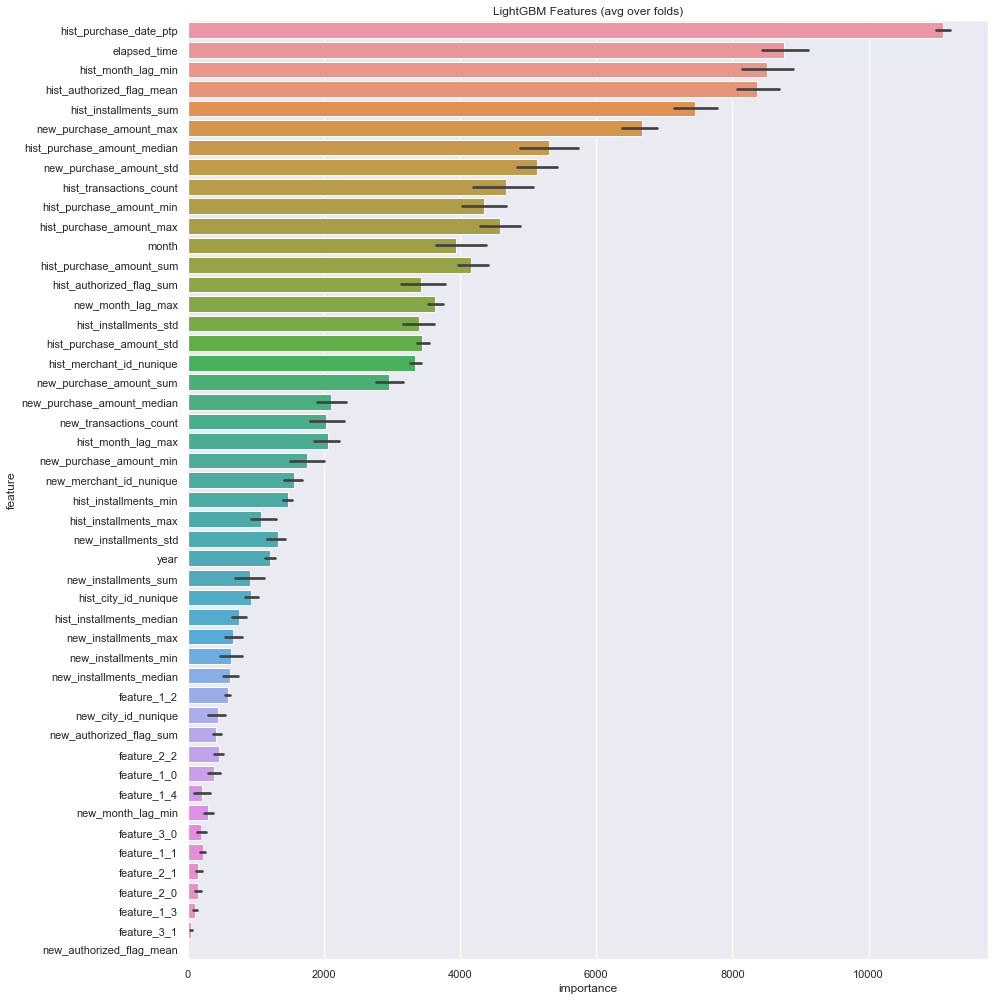

In [30]:
cols = (feature_importance_df_lgb[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_lgb.loc[feature_importance_df_lgb.feature.isin(cols)]

plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [31]:
sub_df = pd.read_csv('test.csv')
sub_df["target"] = 0.5 * predictions_lgb + 0.5 * predictions_xgb
sub_df.to_csv("target_prediction.csv", index=False)

In [32]:
# Creating a dataframe for target prediction file

sub_df = pd.read_csv('target_prediction.csv')
sub_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-04,C_ID_0ab67a22ab,3,3,1,-2.938579
1,2017-01,C_ID_130fd0cbdd,2,3,0,-0.198226
2,2017-08,C_ID_b709037bc5,5,1,1,0.069187
3,2017-12,C_ID_d27d835a9f,2,1,0,0.085094
4,2015-12,C_ID_2b5e3df5c2,5,1,1,-0.741108


In [33]:
# Save the prediction csv file

outputfile = sub_df[['card_id','target']]
outputfile.to_csv('submission.csv', header = True)

# Neural Network

In [34]:
# Adding the target column back for pre-processing data for neural network

train_df["target"] = target

In [35]:
# Filling the missing values for training data

imr = Imputer(missing_values = 'NaN', strategy= 'mean', axis = 0)
imr = imr.fit(train_df)
imputed_train = imr.transform(train_df.values)
train = pd.DataFrame(imputed_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.



In [36]:
# Filling the missing values for test data

from sklearn.preprocessing import Imputer
imrt = Imputer(missing_values = 'NaN', strategy= 'mean', axis = 0)
imrt = imrt.fit(test_df)
imputed_test = imrt.transform(test_df.values)
test = pd.DataFrame(imputed_test)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.



In [37]:
# Dealing with categorical values

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categorical_features = [0])
train = ohe.fit_transform(train).toarray()
test = ohe.transform(test).toarray()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:390: DeprecationWarning:

The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.



In [38]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [39]:
# Splitting into train and test datasets for neural networks

X, y = train.iloc[:, :-1].values , train.iloc[:, 42].values
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [40]:
X_train.shape

(161533, 45)

In [41]:
# Fit the Data using standardscaler

std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

# Final test dataset
test = std.transform(test)

In [42]:
!pip install -q tf-nightly-2.0-preview
! pip install jupyter-tensorboard
! pip install -c conda-forge tensorboard 

  Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: )
No matching distribution found for tf-nightly-2.0-preview
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Could not open requirements file: [Errno 2] No such file or directory: 'conda-forge'
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [43]:
# Importing the tensor board

%load_ext tensorboard.notebook

In [44]:
# NETWORK PARAMETERS

m = len(X_train)
n = 45 # No of features
n_hidden = 45 #Number of hidden neurons

# HYPERPARAMETERS 

batch_size = 200
eta = 0.01
max_epoch = 1000

tf.reset_default_graph() 

In [45]:
# Create a multilayer perceptron model with four hidden layers

def multilayer_perceptron(x):
    
    fm1 = layers.fully_connected(x, n_hidden, activation_fn = tf.nn.relu, scope = 'fm1')
    fm2 = layers.fully_connected(fm1, 20, activation_fn = tf.nn.relu, scope = 'fm2')
    fm3 = layers.dropout(inputs = fm2, keep_prob = 0.5)
    fm4_out = layers.fully_connected(fm3, 1, scope = 'fm4_out')
    
    return fm4_out

In [46]:
# Declare the placeholders for the training data and define the loss and optimizer
# Build model, loss and train 

x = tf.placeholder(tf.float32, name = 'X_train', shape = [None, n])
y = tf.placeholder(tf.float32, name = 'y_train', shape = None)

y_hat = multilayer_perceptron(x)
correct_prediction = tf.square(y - y_hat)
mse = tf.reduce_mean(tf.cast(correct_prediction, "float"))

mtrain = tf.train.AdamOptimizer(learning_rate = eta).minimize(mse)
init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [47]:
# Making batch sizes for training

i = 0
def next_batch(x, y, batch):
    global i
    x, y = x[i: i + batch_size], y[i: i + batch_size]
    i = (i + batch_size) % len(X_train)
    return x, y

In [48]:
# Printing the train data shape

X_train.shape

(161533, 45)

In [49]:
# Batch size

161533// batch_size

807

In [50]:
# Executing the computational graph

with tf.Session() as sess: #Initialize variables  
    sess.run(init) 
    #writer = tf.summary.FileWriter('graphs', sess.graph)
    
# train the model for 1000 epochs
    loss_list = []
    for k in range(max_epoch):
        
        for j in range(807):
            
            batch = next_batch(X_train, y_train, batch_size)
            _, l, p = sess.run([mtrain, mse, y_hat], feed_dict = {x: batch[0], y: batch[1]})

        #if i % 100 == 0:
        print('Epoch {0} : Loss {1}'.format(k,l))
        loss_list.append(l)       
    print("Training Done")
    print("Optimization Finished")

    #Test model 
    correction_prediction = tf.square(y - y_hat)
    
    # Calculate Accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    print("Mean Error:", accuracy.eval({x: batch[0], y: batch[1]}))
    #plt.scatter(batch[1],p)
    
    FileWriter('logs/train', graph=mtrain.graph).close()

Epoch 0 : Loss 0.08799930661916733
Epoch 1 : Loss 0.15556474030017853
Epoch 2 : Loss 0.10229136049747467
Epoch 3 : Loss 0.10698674619197845
Epoch 4 : Loss 0.18937668204307556
Epoch 5 : Loss 0.39424505829811096
Epoch 6 : Loss 0.12376303970813751
Epoch 7 : Loss 0.18515214323997498
Epoch 8 : Loss 0.20290958881378174
Epoch 9 : Loss 0.2379164844751358
Epoch 10 : Loss 0.22176975011825562
Epoch 11 : Loss 0.22286313772201538
Epoch 12 : Loss 0.5128393769264221
Epoch 13 : Loss 0.3517276346683502
Epoch 14 : Loss 0.2736155688762665
Epoch 15 : Loss 0.4228980541229248
Epoch 16 : Loss 0.43049356341362
Epoch 17 : Loss 0.3154788911342621
Epoch 18 : Loss 0.15484608709812164
Epoch 19 : Loss 0.27969878911972046
Epoch 20 : Loss 0.41864871978759766
Epoch 21 : Loss 0.33047938346862793
Epoch 22 : Loss 0.2269054651260376
Epoch 23 : Loss 0.30325472354888916
Epoch 24 : Loss 0.2056708037853241
Epoch 25 : Loss 0.07043053209781647
Epoch 26 : Loss 0.17861442267894745
Epoch 27 : Loss 0.27586615085601807
Epoch 28 : Lo

Epoch 227 : Loss 0.23266911506652832
Epoch 228 : Loss 0.5237970352172852
Epoch 229 : Loss 0.3625138998031616
Epoch 230 : Loss 0.1819317638874054
Epoch 231 : Loss 0.11469997465610504
Epoch 232 : Loss 0.1390060931444168
Epoch 233 : Loss 0.19070422649383545
Epoch 234 : Loss 0.12955273687839508
Epoch 235 : Loss 0.34070703387260437
Epoch 236 : Loss 0.2554103136062622
Epoch 237 : Loss 0.24444663524627686
Epoch 238 : Loss 0.11034833639860153
Epoch 239 : Loss 0.15637628734111786
Epoch 240 : Loss 0.18788689374923706
Epoch 241 : Loss 0.27220767736434937
Epoch 242 : Loss 0.38487520813941956
Epoch 243 : Loss 0.4743155837059021
Epoch 244 : Loss 0.2599865794181824
Epoch 245 : Loss 0.08628189563751221
Epoch 246 : Loss 0.1451636701822281
Epoch 247 : Loss 0.2816545069217682
Epoch 248 : Loss 0.25833553075790405
Epoch 249 : Loss 0.1385791301727295
Epoch 250 : Loss 0.11703404784202576
Epoch 251 : Loss 0.3825509548187256
Epoch 252 : Loss 0.3047736883163452
Epoch 253 : Loss 0.2687302529811859
Epoch 254 : Lo

Epoch 451 : Loss 0.11484499275684357
Epoch 452 : Loss 0.09129457175731659
Epoch 453 : Loss 0.14482100307941437
Epoch 454 : Loss 0.2548111379146576
Epoch 455 : Loss 0.3626677691936493
Epoch 456 : Loss 0.21779634058475494
Epoch 457 : Loss 0.3737700581550598
Epoch 458 : Loss 0.3761917054653168
Epoch 459 : Loss 0.3001444935798645
Epoch 460 : Loss 0.32832685112953186
Epoch 461 : Loss 0.27376094460487366
Epoch 462 : Loss 0.37604227662086487
Epoch 463 : Loss 0.49318671226501465
Epoch 464 : Loss 0.19946132600307465
Epoch 465 : Loss 0.23202544450759888
Epoch 466 : Loss 0.21783335506916046
Epoch 467 : Loss 0.23618218302726746
Epoch 468 : Loss 0.29737889766693115
Epoch 469 : Loss 0.18796907365322113
Epoch 470 : Loss 0.25104913115501404
Epoch 471 : Loss 0.1219516322016716
Epoch 472 : Loss 0.13787734508514404
Epoch 473 : Loss 0.2970849573612213
Epoch 474 : Loss 0.4146268963813782
Epoch 475 : Loss 0.17298440635204315
Epoch 476 : Loss 0.1663733422756195
Epoch 477 : Loss 0.16006715595722198
Epoch 478 

Epoch 675 : Loss 0.16030092537403107
Epoch 676 : Loss 0.130088210105896
Epoch 677 : Loss 0.2241796851158142
Epoch 678 : Loss 0.1846933662891388
Epoch 679 : Loss 0.17886415123939514
Epoch 680 : Loss 0.22773471474647522
Epoch 681 : Loss 0.1461447924375534
Epoch 682 : Loss 0.37259334325790405
Epoch 683 : Loss 0.16484445333480835
Epoch 684 : Loss 0.16935038566589355
Epoch 685 : Loss 0.2591571807861328
Epoch 686 : Loss 0.33351466059684753
Epoch 687 : Loss 0.23538964986801147
Epoch 688 : Loss 0.14463499188423157
Epoch 689 : Loss 0.14807717502117157
Epoch 690 : Loss 0.15827621519565582
Epoch 691 : Loss 0.136818990111351
Epoch 692 : Loss 0.22814823687076569
Epoch 693 : Loss 0.23890161514282227
Epoch 694 : Loss 0.37470686435699463
Epoch 695 : Loss 0.3598078489303589
Epoch 696 : Loss 0.31586015224456787
Epoch 697 : Loss 0.22312353551387787
Epoch 698 : Loss 0.1700565218925476
Epoch 699 : Loss 0.1401853859424591
Epoch 700 : Loss 0.22653579711914062
Epoch 701 : Loss 0.30641210079193115
Epoch 702 : 

Epoch 900 : Loss 0.2188986986875534
Epoch 901 : Loss 0.1463966816663742
Epoch 902 : Loss 0.1365872621536255
Epoch 903 : Loss 0.15187573432922363
Epoch 904 : Loss 0.16498421132564545
Epoch 905 : Loss 0.16067557036876678
Epoch 906 : Loss 0.1888895481824875
Epoch 907 : Loss 0.2567296028137207
Epoch 908 : Loss 0.0768800899386406
Epoch 909 : Loss 0.12049691379070282
Epoch 910 : Loss 0.3673732578754425
Epoch 911 : Loss 0.5637964606285095
Epoch 912 : Loss 0.34233802556991577
Epoch 913 : Loss 0.49377983808517456
Epoch 914 : Loss 0.16719625890254974
Epoch 915 : Loss 0.12925919890403748
Epoch 916 : Loss 0.2053699940443039
Epoch 917 : Loss 0.31487882137298584
Epoch 918 : Loss 0.17701122164726257
Epoch 919 : Loss 0.1685791015625
Epoch 920 : Loss 0.2873300313949585
Epoch 921 : Loss 0.37881144881248474
Epoch 922 : Loss 0.17338484525680542
Epoch 923 : Loss 0.17272035777568817
Epoch 924 : Loss 0.4171329140663147
Epoch 925 : Loss 0.323010116815567
Epoch 926 : Loss 0.4835985004901886
Epoch 927 : Loss 0.

In [63]:
#loss_list.remove(171.1658477783203)

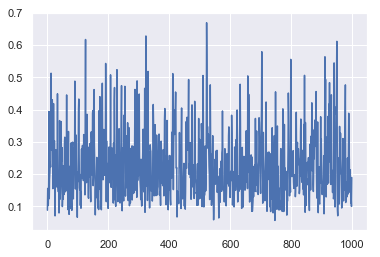

In [58]:
plt.plot(loss_list)

In [66]:
with tf.Session() as sess: #Initialize variables  
    sess.run(init) 
   
    Test_MSE=sess.run(y_hat,feed_dict = {x: X_test}) # generate some examples
   


In [72]:
# Printing Mean Square Error for Test Set
import math 
from sklearn.metrics import mean_squared_error
# print('Test MSE:')
# (mean_squared_error(y_test, Test_MSE))